In [1]:
import cv2
import glob

import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython.display import Image

In [2]:
sns.set()

#### Definitions

In [3]:
size = (200, 200)
batch_size = 100

#### Paths to images

In [4]:
melanoma_path = "../data/melanoma/"
nevus_path = "../data/melanoma/"
seborrheic_path = "../data/seborrheic_keratosis/" # Normal 

### Image loader

Notice that we have to manually set the color palette to RGB since opencv (cv2) defaults to reading the images as BGR - This is done by specifying ```cv2.COLOR_BGR2RGB```

In [5]:
def load_images(path):
    """ Load all jpg images from the folder at path

    args:
        Path: Path to folder with imgaes
        
    returns:
        images: 4D List with all images as arrays
    
    """
    # Get (file)names of all images in the seborrheic folder
    imagenames = glob.glob(path + "*.jpg")

    # Load all images in the seborrheic folder based on the image names
    images = [cv2.imread(img, cv2.COLOR_BGR2RGB) for img in imagenames]

    # Resize all images to 200 by 200 (defined under definitions) for easier handling
    images = [cv2.resize(img, size) for img in images]
    
    return np.asarray(images)

In [6]:
# Use the load_images function to load all images
melanoma_images = load_images(melanoma_path)
seborrheic_images = load_images(seborrheic_path)

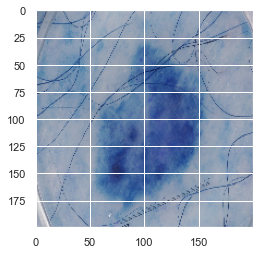

In [7]:
plt.imshow(melanoma_images[0])

In [8]:
print(" Number of melanoma images:", np.shape(melanoma_images)[0], "\n", 
      "Shape of melanoma images:", np.shape(melanoma_images)[1:4])

 Number of melanoma images: 30 
 Shape of melanoma images: (200, 200, 3)


In [9]:
print(" Number of melanoma images:", np.shape(seborrheic_images)[0], "\n", 
      "Shape of melanoma images:", np.shape(seborrheic_images)[1:4])

 Number of melanoma images: 42 
 Shape of melanoma images: (200, 200, 3)


## Preprocssing

In [10]:
melanoma_size = np.shape(melanoma_images)[0]
seborrheic_size = np.shape(seborrheic_images)[0]

Melanoma class: 1  
Seborrheic class: 0

In [11]:
X_train = np.concatenate([melanoma_images, seborrheic_images], axis=0)
y_train = np.append(np.ones(melanoma_size), np.zeros(seborrheic_size))

In [12]:
np.shape(X_train), np.shape(y_train)

((72, 200, 200, 3), (72,))

## Modelling

In [13]:
def SimpleModel(n_classes=1):
    """Simple keras ConvNet model"""
    
    # Input layer
    inputs = tf.keras.layers.Input(shape=(size[0], size[1], 3))
    
    # First conv layer
    conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu')(inputs)
    pool1 = tf.keras.layers.MaxPool2D(2, 2)(conv1)
    
    # Second conv layer
    conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(pool1)
    pool2 = tf.keras.layers.MaxPool2D(2, 2)(conv2)
    
    # Flatten conv layer
    flatten = tf.keras.layers.Flatten()(pool2)
    
    # First dense layer
    dense1 = tf.keras.layers.Dense(1024, activation='relu')(flatten)
    dropped = tf.keras.layers.Dropout(rate=0.5)(dense1)
    
    # Output layer 
    outputs = tf.keras.layers.Dense(n_classes, activation='softmax')(dropped)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                  metrics=['acc'])

    return model

#### Initialize model

In [19]:
model = SimpleModel()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 196, 32)      2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147456)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1509

In [15]:
# make early stopping callback
earlystopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=0.001,
    patience=5,
    mode='max',
    restore_best_weights=True
)

In [16]:
# fit the model and get training history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=10,
    # validation_data=(x_val, y_val),
    # callbacks=[earlystopper]
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 72 samples
Epoch 1/10
72/72 [==============================] - 3s 35ms/sample - loss: 8.9444 - acc: 0.4167
Epoch 2/10
72/72 [==============================] - 2s 31ms/sample - loss: 8.9444 - acc: 0.4167
Epoch 3/10
72/72 [==============================] - 2s 29ms/sample - loss: 8.9444 - acc: 0.4167
Epoch 4/10
72/72 [==============================] - 2s 29ms/sample - loss: 8.9444 - acc: 0.4167
Epoch 5/10
72/72 [==============================] - 2s 30ms/sample - loss: 8.9444 - acc: 0.4167
Epoch 6/10
72/72 [==============================] - 2s 30ms/sample - loss: 8.9444 - acc: 0.4167
Epoch 7/10
72/72 [==============================] - 2s 31ms/sample - loss: 8.9444 - acc: 0.4167
Epoch 8/10
72/72 [==============================] - 2s 31ms/sample - loss: 8.9444 - acc: 0.4167
Epoch 9/10
72/72 [==============================] - 2s 31ms/sample - loss: 8.9444 - acc: 0.4167
Epoch 10/10
72/72 [===

## Illustrate training history

In [17]:
def plot(history):
    # plot history for loss and accuracy
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 16))

    ax1.plot(history.history['acc'])
    # ax1.plot(history.history['val_acc'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'test'], loc='upper left')

    ax2.plot(history.history['loss'])
    # ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')

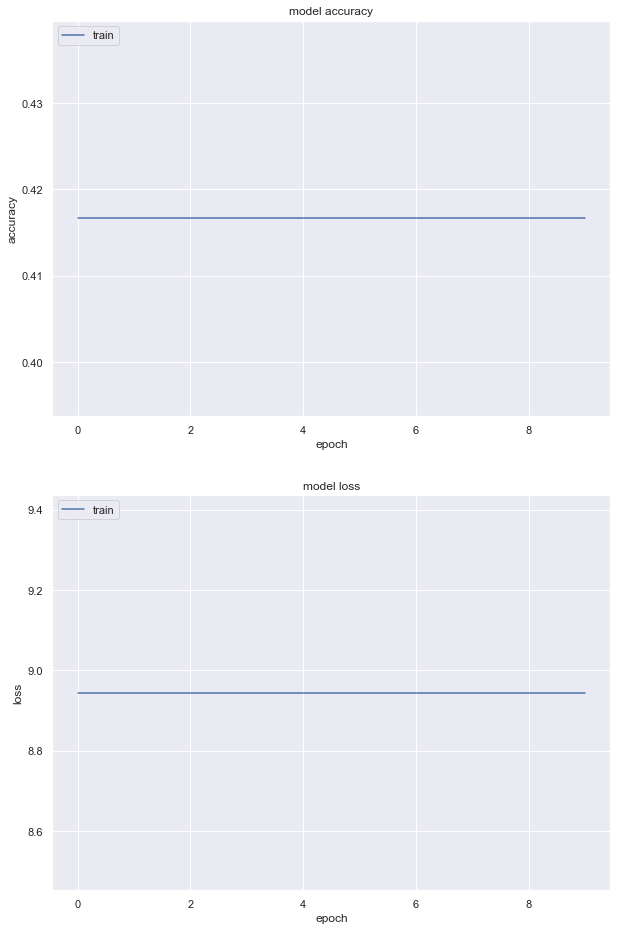

In [18]:
plot(history)